Test copy small

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the GPT-2 XL tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
model = GPT2LMHeadModel.from_pretrained('gpt2-xl')
model.to(device)
model.eval()

# Enable outputting hidden states
model.config.output_hidden_states = True

# Create a long text with a repeated span for summarization
text = (
    "Once upon a time in a land far, far away, there lived a wise old king. "
    "He ruled his kingdom with justice and kindness, and all his subjects loved him dearly. "
    "One day, a young traveler arrived at the kingdom. He had heard tales of the king's wisdom and sought his counsel. "
    "The wise old king welcomed the traveler warmly. "
    "He ruled his kingdom with justice and kindness, and all his subjects loved him dearly. "  # Repeated span
    "The traveler was amazed by the prosperity and happiness of the people. "
    "He decided to stay and learn from the king. "
    "Years passed, and the traveler became a trusted advisor to the king. "
)

# Tokenize the text
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

# Get the number of tokens
num_tokens = input_ids.shape[1]

# Generate position IDs
position_ids = torch.arange(num_tokens, dtype=torch.long, device=device)
position_ids = position_ids.unsqueeze(0)

# Generate attention mask
attention_mask = torch.ones_like(input_ids)

# Get the token embeddings and positional embeddings
with torch.no_grad():
    token_embeddings = model.transformer.wte(input_ids)
    positional_embeddings = model.transformer.wpe(position_ids)
    input_embeddings = token_embeddings + positional_embeddings

# Convert input_ids to list for easy manipulation
tokens = input_ids[0].tolist()

# Decode tokens for verification
decoded_tokens = [tokenizer.decode([token]) for token in tokens]

# Print tokens and their decoded forms
print("Tokens and their decoded forms:")
for i, (token_id, token_text) in enumerate(zip(tokens, decoded_tokens)):
    print(f"Token {i}: {token_id} -> {repr(token_text)}")

# Manually identify the positions of the repeated spans
# First occurrence
t1_start = 19
t1_end = 34  # Adjusted to exclude the period if necessary

# Second occurrence
t2_start = 71
t2_end = 86  # Adjusted to exclude the period if necessary

# Verify that the tokens in both spans are the same
print("\nFirst occurrence tokens:")
for i in range(t1_start, t1_end + 1):
    print(f"Token {i}: {tokens[i]} -> {repr(decoded_tokens[i])}")

print("\nSecond occurrence tokens:")
for i in range(t2_start, t2_end + 1):
    print(f"Token {i}: {tokens[i]} -> {repr(decoded_tokens[i])}")

# Extract embeddings for the first occurrence
embeds_t1 = input_embeddings[:, t1_start:t1_end + 1, :]
pos_embeds_t1 = positional_embeddings[:, t1_start:t1_end + 1, :]

# Derotate the embeddings
embeds_t1_derotated = embeds_t1 - pos_embeds_t1

# Get positional embeddings for the second occurrence
pos_embeds_t2 = positional_embeddings[:, t2_start:t2_end + 1, :]

# Rerotate the embeddings to the new positions
embeds_t1_adjusted = embeds_t1_derotated + pos_embeds_t2

# Replace the embeddings of the second occurrence with the adjusted embeddings
input_embeddings_adjusted = input_embeddings.clone()
input_embeddings_adjusted[:, t2_start:t2_end + 1, :] = embeds_t1_adjusted

# Pass the original embeddings through the model
with torch.no_grad():
    outputs_original = model(inputs_embeds=input_embeddings, attention_mask=attention_mask, position_ids=position_ids)
    logits_original = outputs_original.logits

# Pass the adjusted embeddings through the model
with torch.no_grad():
    outputs_adjusted = model(inputs_embeds=input_embeddings_adjusted, attention_mask=attention_mask, position_ids=position_ids)
    logits_adjusted = outputs_adjusted.logits

# Compare the logits of the token following the repeated span
next_token_position = t2_end + 1
logits_original_next = logits_original[:, next_token_position, :]
logits_adjusted_next = logits_adjusted[:, next_token_position, :]

# Get the top predicted tokens
top_k = 5
prob_original = torch.softmax(logits_original_next, dim=-1)
prob_adjusted = torch.softmax(logits_adjusted_next, dim=-1)

top_tokens_original = torch.topk(prob_original, top_k, dim=-1)
top_tokens_adjusted = torch.topk(prob_adjusted, top_k, dim=-1)

print("\nTop predictions after the original repeated span:")
for idx in top_tokens_original.indices[0]:
    print(tokenizer.decode([idx.item()]))

print("\nTop predictions after the adjusted repeated span:")
for idx in top_tokens_adjusted.indices[0]:
    print(tokenizer.decode([idx.item()]))

# Check if the predictions are the same
are_predictions_same = torch.equal(top_tokens_original.indices, top_tokens_adjusted.indices)
print(f"\nAre the top {top_k} predictions the same after adjustment? {are_predictions_same}")

In [1]:
def find_sublist(a, b):
    """
    Finds the start and end indices of list a within list b.

    Args:
        a (list): The sublist to find.
        b (list): The list to search in.

    Returns:
        tuple: A tuple (start_index, end_index) if sublist is found.
        None: If the sublist is not found.
    """
    len_a = len(a)
    len_b = len(b)

    for i in range(len_b - len_a + 1):
        if b[i:i+len_a] == a:
            return i, i + len_a - 1
    return None
a = [2, 3, 4]
b = [1, 2, 3, 4, 5]

result = find_sublist(a, b)
if result:
    print(f"Sublist found from index {result[0]} to {result[1]}")
else:
    print("Sublist not found.")


Sublist found from index 1 to 3


In [12]:
from difflib import SequenceMatcher

def find_second_occurrence_fuzzy(list_a, list_b, min_ratio=0.8):
    """
    Finds the starting index of the second occurrence of list_a in list_b
    using approximate matching.

    Parameters:
    list_a (list): The sublist to find.
    list_b (list): The list in which to search for the sublist.
    min_ratio (float): Minimum similarity ratio to consider a match (0 to 1).

    Returns:
    int: The starting index of the second occurrence of list_a in list_b.
         Returns -1 if the second occurrence is not found.
    """
    len_a = len(list_a)
    len_b = len(list_b)
    occurrences = []

    for i in range(len_b - len_a + 1):
        # Compare slices using SequenceMatcher
        s = SequenceMatcher(None, list_a, list_b[i:i + len_a])
        ratio = s.ratio()

        if ratio >= min_ratio:
            occurrences.append(i)
            if len(occurrences) == 2:
                return occurrences[1]  # Return the index of the second occurrence

    # If the second occurrence is not found
    return -1

# Example usage with your lists:
list_a = ['Dad', 'aji', ' lost', ' his', ' mother', ' and', ' took', ' to', ' living', ' with', ' his', ' maternal', ' uncle', ' Nar', 'ayan', ' Dh', 'ur', 'm', 'aji', ' ', '.']
list_b = ['Base', ' sentence', ':', ' Dad', 'aji', ' lost', ' his', ' mother', ' and', ' took', ' to', ' living', ' with', ' his', ' maternal', ' uncle', ' Nar', 'ayan', ' Dh', 'ur', 'm', 'aji', ' ', '.', '\n', 'Ph', 'rase', ' to', ' inserted', ':', ' In', ' the', ' meanwhile', ' ', ',', '\n', 'Edited', ' sentence', ':', ' In', ' the', ' meanwhile', ' ', ',', ' Dad', 'aji', ' lost', ' his', ' mother', ' and', ' took', ' to', ' living', ' with', ' his', ' maternal', ' uncle', ' Nar', 'ayan', ' Dh', 'ur', 'm', 'aji', ' ', '.']

index = find_second_occurrence_fuzzy(list_a, list_b)

if index != -1:
    print(f"The second occurrence of list_a starts at index {index}.")
else:
    print("The sublist does not occur twice in list_b.")


The second occurrence of list_a starts at index 1.


In [10]:
def tokens_match(token_a, token_b):
    # Custom comparison function
    return token_a.strip() == token_b.strip()

def find_second_occurrence_custom(list_a, list_b):
    len_a = len(list_a)
    len_b = len(list_b)
    occurrences = []

    for i in range(len_b - len_a + 1):
        match = True
        for j in range(len_a):
            if not tokens_match(list_a[j], list_b[i + j]):
                match = False
                break
        if match:
            occurrences.append(i)
            if len(occurrences) == 2:
                return occurrences[1]
    return -1

# Example usage:
index = find_second_occurrence_custom(list_a, list_b)
print(f"The second occurrence of list_a starts at index {index}.")


The second occurrence of list_a starts at index 44.


In [11]:
list_b[44]

' Dad'

In [6]:
def find_second_occurrence(list_a, list_b):
    # Counter to track occurrences
    occurrence_count = 0

    # Debugging: Print the lists
    print("List A:", list_a)
    print("List B:", list_b)

    # Iterate through list_b to find all occurrences of list_a
    for i in range(len(list_b) - len(list_a) + 1):
        # Check if the current slice of list_b matches list_a
        if list_b[i:i + len(list_a)] == list_a:
            occurrence_count += 1
            print(f"Match found at index {i}, occurrence count: {occurrence_count}")
            if occurrence_count == 2:  # Return index when the second occurrence is found
                return i
    return -1  # Return -1 if the second occurrence is not found

# Example lists
list_a = ['Dad', 'aji', ' lost', ' his', ' mother', ' and', ' took', ' to', ' living', ' with', ' his', ' maternal', ' uncle', ' Nar', 'ayan', ' Dh', 'ur', 'm', 'aji', ' ', '.']
list_b = ['Base', ' sentence', ':', ' Dad', 'aji', ' lost', ' his', ' mother', ' and', ' took', ' to', ' living', ' with', ' his', ' maternal', ' uncle', ' Nar', 'ayan', ' Dh', 'ur', 'm', 'aji', ' ', '.', '\n', 'Ph', 'rase', ' to', ' inserted', ':', ' In', ' the', ' meanwhile', ' ', ',', '\n', 'Edited', ' sentence', ':', ' In', ' the', ' meanwhile', ' ', ',', ' Dad', 'aji', ' lost', ' his', ' mother', ' and', ' took', ' to', ' living', ' with', ' his', ' maternal', ' uncle', ' Nar', 'ayan', ' Dh', 'ur', 'm', 'aji', ' ', '.']

# Find the second occurrence
second_index = find_second_occurrence(list_a, list_b)

print("Index of the second occurrence:", second_index)


List A: ['Dad', 'aji', ' lost', ' his', ' mother', ' and', ' took', ' to', ' living', ' with', ' his', ' maternal', ' uncle', ' Nar', 'ayan', ' Dh', 'ur', 'm', 'aji', ' ', '.']
List B: ['Base', ' sentence', ':', ' Dad', 'aji', ' lost', ' his', ' mother', ' and', ' took', ' to', ' living', ' with', ' his', ' maternal', ' uncle', ' Nar', 'ayan', ' Dh', 'ur', 'm', 'aji', ' ', '.', '\n', 'Ph', 'rase', ' to', ' inserted', ':', ' In', ' the', ' meanwhile', ' ', ',', '\n', 'Edited', ' sentence', ':', ' In', ' the', ' meanwhile', ' ', ',', ' Dad', 'aji', ' lost', ' his', ' mother', ' and', ' took', ' to', ' living', ' with', ' his', ' maternal', ' uncle', ' Nar', 'ayan', ' Dh', 'ur', 'm', 'aji', ' ', '.']
Index of the second occurrence: -1


In [ ]:
['Dad', 'aji', ' lost', ' his', ' mother', ' and', ' took', ' to', ' living', ' with', ' his', ' maternal', ' uncle', ' Nar', 'ayan', ' Dh', 'ur', 'm', 'aji', ' ', '.']
['Base', ' sentence', ':', ' Dad', 'aji', ' lost', ' his', ' mother', ' and', ' took', ' to', ' living', ' with', ' his', ' maternal', ' uncle', ' Nar', 'ayan', ' Dh', 'ur', 'm', 'aji', ' ', '.', '\n', 'Ph', 'rase', ' to', ' inserted', ':', ' In', ' the', ' meanwhile', ' ', ',', '\n', 'Edited', ' sentence', ':', ' In', ' the', ' meanwhile', ' ', ',', ' Dad', 'aji', ' lost', ' his', ' mother', ' and', ' took', ' to', ' living', ' with', ' his', ' maternal', ' uncle', ' Nar', 'ayan', ' Dh', 'ur', 'm', 'aji', ' ', '.']


Hidden representation

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the GPT-2 XL tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
model = GPT2LMHeadModel.from_pretrained('gpt2-xl')
model.to(device)
model.eval()

# Create a long text with a repeated span
text = (
    "Once upon a time in a land far, far away, there lived a wise old king. "
    "He ruled his kingdom with justice and kindness, and all his subjects loved him dearly. "
    "One day, a young traveler arrived at the kingdom. He had heard tales of the king's wisdom and sought his counsel. "
    "The wise old king welcomed the traveler warmly. "
    "He ruled his kingdom with justice and kindness, and all his subjects loved him dearly. "  # Repeated span
    "The traveler was amazed by the prosperity and happiness of the people. "
    "He decided to stay and learn from the king. "
    "Years passed, and the traveler became a trusted advisor to the king. "
)

# Tokenize the text
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

# Convert input_ids to list for easy manipulation
tokens = input_ids[0].tolist()

# Decode tokens for verification
decoded_tokens = [tokenizer.decode([token]) for token in tokens]

# Manually identify the positions of the repeated spans
# First occurrence
t1_start = 19
t1_end = 34  # Adjust if necessary

# Second occurrence
t2_start = 71
t2_end = 86  # Adjust if necessary

# Verify that the tokens in both spans are the same
print("\nFirst occurrence tokens:")
for i in range(t1_start, t1_end + 1):
    print(f"Token {i}: {tokens[i]} -> {repr(decoded_tokens[i])}")

print("\nSecond occurrence tokens:")
for i in range(t2_start, t2_end + 1):
    print(f"Token {i}: {tokens[i]} -> {repr(decoded_tokens[i])}")

# Function to adjust hidden states
def adjust_hidden_states(module, input, output):
    # output is a tuple: (hidden_states, presents)
    hidden_states = output[0]  # Extract the hidden states tensor
    # Copy the hidden states from the first occurrence to the second occurrence
    hidden_states[:, t2_start:t2_end+1, :] = hidden_states[:, t1_start:t1_end+1, :]
    # Return the modified output as a tuple
    return (hidden_states,) + output[1:]

# Register the hook on the transformer blocks
hooks = []
for idx, block in enumerate(model.transformer.h):
    hook = block.register_forward_hook(adjust_hidden_states)
    hooks.append(hook)

# Run the model with the hooks (adjusted)
with torch.no_grad():
    outputs_adjusted = model(input_ids)
    logits_adjusted = outputs_adjusted.logits

# Remove hooks after use
for hook in hooks:
    hook.remove()

# Run the model without adjustments for comparison
with torch.no_grad():
    outputs_original = model(input_ids)
    logits_original = outputs_original.logits

# Compare the logits of the token following the repeated span
for i in range(1, 10):
    next_token_position = t2_end + i
    logits_adjusted_next = logits_adjusted[:, next_token_position, :]
    logits_original_next = logits_original[:, next_token_position, :]

    # Get the top predicted tokens
    top_k = 5
    prob_original = torch.softmax(logits_original_next, dim=-1)
    prob_adjusted = torch.softmax(logits_adjusted_next, dim=-1)

    top_tokens_original = torch.topk(prob_original, top_k, dim=-1)
    top_tokens_adjusted = torch.topk(prob_adjusted, top_k, dim=-1)

    print("\nTop predictions after the adjusted repeated span:")
    for idx in top_tokens_adjusted.indices[0]:
        print(tokenizer.decode([idx.item()]))

    print("\nTop predictions after the original repeated span:")
    for idx in top_tokens_original.indices[0]:
        print(tokenizer.decode([idx.item()]))

    # Check if the predictions are the same
    are_predictions_same = torch.equal(top_tokens_original.indices, top_tokens_adjusted.indices)
    print(f"\nAre the top {top_k} predictions the same after adjustment? {are_predictions_same}")


/home/phu.hoang/.conda/envs/copy_mech/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



First occurrence tokens:
Token 19: 679 -> ' He'
Token 20: 8879 -> ' ruled'
Token 21: 465 -> ' his'
Token 22: 13239 -> ' kingdom'
Token 23: 351 -> ' with'
Token 24: 5316 -> ' justice'
Token 25: 290 -> ' and'
Token 26: 23887 -> ' kindness'
Token 27: 11 -> ','
Token 28: 290 -> ' and'
Token 29: 477 -> ' all'
Token 30: 465 -> ' his'
Token 31: 7481 -> ' subjects'
Token 32: 6151 -> ' loved'
Token 33: 683 -> ' him'
Token 34: 46379 -> ' dearly'

Second occurrence tokens:
Token 71: 679 -> ' He'
Token 72: 8879 -> ' ruled'
Token 73: 465 -> ' his'
Token 74: 13239 -> ' kingdom'
Token 75: 351 -> ' with'
Token 76: 5316 -> ' justice'
Token 77: 290 -> ' and'
Token 78: 23887 -> ' kindness'
Token 79: 11 -> ','
Token 80: 290 -> ' and'
Token 81: 477 -> ' all'
Token 82: 465 -> ' his'
Token 83: 7481 -> ' subjects'
Token 84: 6151 -> ' loved'
Token 85: 683 -> ' him'
Token 86: 46379 -> ' dearly'

Top predictions after the adjusted repeated span:
 He
 The
 But
 "
 They

Top predictions after the original repeate

load model

In [1]:
for i in tqdm(range(1)):
    base_sent = preprocessing(base_sents[i])
    phrase = preprocessing(phrases[i])
    edited_sent = preprocessing(edited_sents[i])

    prompt = f"Base sentence: {base_sent}\nPhrase to insert: {phrase}\nEdited sentence: {edited_sent}"

    # Find the indices of the base sentence tokens in the edited sentence
    result = find_base_sent(base_sent, prompt)
    if not result:
        continue  # Skip if matching fails
    matching_indices_1st, matching_indices_2nd, input_ids, edited_encoded = result

    # Function to adjust hidden states
    def adjust_hidden_states(module, input, output):
        print("adjust_hidden_states called")
        # output is a tuple: (hidden_states, presents)
        hidden_states = output[0]  # Extract the hidden states tensor
        # Copy the hidden states from the first occurrence to the second occurrence
        hidden_states[:, matching_indices_2nd, :] = hidden_states[:, matching_indices_1st, :]
        # Return the modified output as a tuple
        return (hidden_states,) + output[1:]

    print(f"Using adjust_hidden_states function: {adjust_hidden_states}")

    # Register the hook on the transformer blocks
    hooks = []
    for idx, block in enumerate(model.transformer.h):
        print(f"Registering hook on layer {idx} with function {adjust_hidden_states}")
        hook = block.register_forward_hook(adjust_hidden_states)
        hooks.append(hook)

    # Run the model with the hooks (adjusted)
    with torch.no_grad():
        outputs_adjusted = model(input_ids)
        logits_adjusted = outputs_adjusted.logits

    # Remove hooks after use
    for hook in hooks:
        hook.remove()

    # Run the model without adjustments for comparison
    with torch.no_grad():
        outputs_original = model(input_ids)
        logits_original = outputs_original.logits

    # Rest of your code...


ImportError: attempted relative import with no known parent package

TinyLlama

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Replace with the model name or path
model_name = "TinyLlama/TinyLlama_v1.1"  # Replace with "phi-3-mini" for the other model

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the model
model = AutoModelForCausalLM.from_pretrained(model_name)

pytorch_model.bin:  95%|#########4| 4.16G/4.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

In [2]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): 

GPT2

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the GPT-2 XL tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
model = GPT2LMHeadModel.from_pretrained('gpt2-xl')
model

/home/phu.hoang/.conda/envs/copy_mech/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

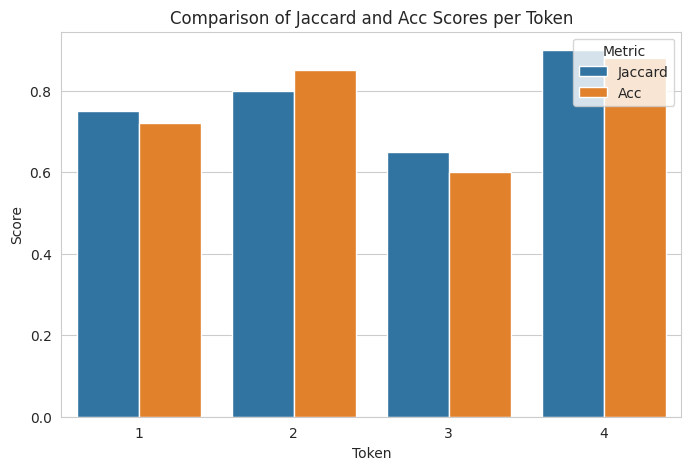

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jaccard = np.array([0.75, 0.80, 0.65, 0.90])
acc = np.array([0.72, 0.85, 0.60, 0.88])

# Create a DataFrame for plotting
data = pd.DataFrame({
    'Token': np.arange(len(jaccard)) + 1,  # Token IDs starting from 1
    'Jaccard': jaccard,
    'Acc': acc
})

# Melt the DataFrame to a long format suitable for Seaborn
data_melted = data.melt(id_vars='Token', value_vars=['Jaccard', 'Acc'], 
                        var_name='Metric', value_name='Score')

# Create a grouped bar plot
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Token', y='Score', hue='Metric', data=data_melted)

# Add a title and labels
plt.title('Comparison of Jaccard and Acc Scores per Token')
plt.xlabel('Token')
plt.ylabel('Score')

# Optionally, adjust the legend position
plt.legend(title='Metric', loc='upper right')

plt.show()
